### Packages and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,boxcox,yeojohnson
import sklearn
from sklearn.preprocessing import LabelEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier


In [2]:
#Reading csv
df = pd.read_csv("bank_marketing_weka_dataset.csv")

#Separate features
X = df.drop(['y'], axis=1)

#Target variable
y = df['y']

#Transform 'y' to binary
y = y.map(dict(yes=1, no=0))

#Continuos variables
conti = X.select_dtypes(include=np.number)

In [3]:
#Features initial state
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199.0,4,-1.0,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226.0,1,-1.0,0,unknown


## Target variable balance

In [4]:
y.value_counts()

0    4000
1     521
Name: y, dtype: int64

# Features engineering

## Modifications for the whole dataset

### Binary values
Variables: 'default', 'housing', 'loan'\
Values: 'yes', 'no'\
Method: map to yes=1, no=0

In [5]:
X = X.replace('yes', 1)
X = X.replace('no', 0)

### Month variable
Values: string abbreviations\
Method: transform to numerical

In [6]:
X.month = X.month.map(dict(
jan=1, feb=2, mar=3, apr=4, may=5, jun=6,
jul=7, aug=8, sep=9, oct=10, nov=11, dec=12))

## Train test split
Now we split the dataset to train and test parts to prevent data leakage in the future model leaning.

In [7]:
#Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

## Continuous variables

### Train set

In [8]:
def skew(X, conti):
    '''Calculates skewness of continuous variables in dataset. conti - var list
    returns columns with skewness>2'''
    skewed = []
    for column in conti.columns:
        if conti[column].skew()>2:
            skewed.append(column)
        print(f'{column.capitalize()} skew = {conti[column].skew()}')
    return(skewed)

In [9]:
skew_train = skew(X_train, conti)

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


It is known that ML algorithms tend to perform worse if they have to deal with skewed data. Here we arbitrally have chosen columns with skewness above 2 and transform them, to reduce that parameter.

In [10]:
def skew_reduce(X, skewed):
    '''Applies boxcox or yeojohnson transform on skew vars'''
    for column in skewed:
        if X[column].min()>0:
            print(pd.Series(boxcox(X[column])[0]).skew(),f'{column} boxcox')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(boxcox(X[column])[0])
        else:
            print(pd.Series(yeojohnson(X[column])[0]).skew(),f'{column} yeojohnson')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(yeojohnson(X[column])[0])

Ideally we would like to use boxcox transormation for all our chosen data, but this type of transormation does not work with negative values. Instead of trying to add some constant to these columns with non-positive values we decided to use yeojohnson transormation which is capable of dealing with negative data. As we can see in all of our columns we have managed to reduce skewness massively.

In [11]:
skew_reduce(X_train, skew_train)

1.290840421959374 balance yeojohnson
0.01344882485941695 duration boxcox
0.16766062091805645 campaign boxcox
1.6668067185477198 pdays yeojohnson
1.6665615521189976 previous yeojohnson


### Test set

In [12]:
skew_test = skew(X_test, conti)

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


In [13]:
skew_reduce(X_test, skew_test)

2.7233130991276724 balance yeojohnson
0.023438790518874802 duration boxcox
0.15457242388543432 campaign boxcox
1.6613073918077546 pdays yeojohnson
1.6609394380712006 previous yeojohnson


## Categorical variables

In [14]:
#List of categorical variables
X.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'contact', 'poutcome'], dtype='object')

### Variables: 'job', 'marital', 'education', 'poutcom', 'contact'

Thanks to EDA we know that:

- 'unknown' values are present
- 'job', 'education', 'poutcom' seem to have impact on target variable
- values distributions have no dangerous disparities (in terms of using the target encoding method)

Hence, we decide to:

 - leave the 'unknown' values, as it represents best the idea of the missing information in our case
 - apply target encoding method to variables related with target variable
 - apply one-hot encoding to other variables
 
Expecting target encoding to reflect the relationship of variables with target variable - where it is present according to EDA - and one-hot method to neutrally pass on values of other variables.\
\
For second approach to compere results we decide to apply target encoding for all of these features.

In [15]:
#Approach 1
X1_train = X_train.copy()
X1_test = X_test.copy()

#Target encoding train set
te = TargetEncoder()
X1_train.loc[:, ['job', 'education', 'poutcome']] = te.fit_transform(X1_train.loc[:, ['job', 'education', 'poutcome']], y_train)
#test set
X1_test.loc[:, ['job', 'education', 'poutcome']] = te.transform(X1_test.loc[:, ['job', 'education', 'poutcome']])

#One-hot encoding
X1_train = pd.get_dummies(X1_train, columns=['marital', 'contact'])
X1_test = pd.get_dummies(X1_test, columns=['marital', 'contact'])

#For future
cols = X1_train.columns

In [16]:
#Approach 2
X2_train = X_train.copy()
X2_test = X_test.copy()

#Target encoding for all variables
te2 = TargetEncoder()
cols_to_te = ['job', 'education', 'poutcome', 'marital', 'contact']
X2_train.loc[:, cols_to_te] = te2.fit_transform(X2_train.loc[:, cols_to_te], y_train)
X2_test.loc[:, cols_to_te] = te2.transform(X2_test.loc[:, cols_to_te])

Scaling the data just for sake we might use alghoritm that require standarized input.

In [17]:
scaler = StandardScaler()
scaler2 = StandardScaler()

X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

X2_train = scaler2.fit_transform(X2_train)
X2_test = scaler2.transform(X2_test)

# Modeling

In [18]:
def modeling(X_train, y_train):
    
    #cv folds
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    
    #cv scores
    scoring = {'precision': 'precision_macro',
               'recall': 'recall_macro',
               'accuracy': 'accuracy',
               'auc': 'roc_auc',}
    
    #Logistic regression
    logistic =  LogisticRegression(C=0.001,solver='saga',random_state=42)
    r_log = cross_validate(logistic,X_train,y_train,scoring=scoring, cv=kfold)
    
    #xgb
    params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8,'n_estimators':1000,'random_state':42}
    xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
    r_xgb = cross_validate(xg, X_train, y_train, cv=kfold, scoring=scoring)
    
    #random forest
    params = {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500,'max_features':'auto','random_state':42}
    tree = RandomForestClassifier(**params)

    r_ranforest = cross_validate(tree,X_train,y_train,scoring=scoring,cv=kfold)
    
    return([r_log, r_ranforest, r_xgb])

In [19]:
result = modeling(X1_train,y_train)

In [20]:
result2 = modeling(X2_train,y_train)

# Validation scores

Scores means from cross-validation are presented below for three tested algorithms and two features engineering approaches. We observe satisfying accuracy and auc, but recall needs to be improved in futer. Its low score is propably caused by imbalance in target variable.\
Algorithms results are suprisingly very similar. XGBoost performed best in recall score.

In [21]:
r1 = pd.DataFrame(result[0]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r2 = pd.DataFrame(result2[0]).mean()
r = pd.DataFrame({'X1': r1.values, 'X2': r2.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("Logistic regression:")
r

Logistic regression:


,X1,X2
validate_precision,0.441512,0.441512
validate_recall,0.500000,0.500000
validate_accuarcy,0.883024,0.883024
validate_auc,0.848418,0.842026


In [22]:
r1 = pd.DataFrame(result[1]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r2 = pd.DataFrame(result2[1]).mean()
r = pd.DataFrame({'X1': r1.values, 'X2': r2.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("Random forest:")
r

Random forest:


,X1,X2
validate_precision,0.710101,0.744105
validate_recall,0.506886,0.525202
validate_accuarcy,0.883025,0.887174
validate_auc,0.869381,0.877124


In [23]:
r1 = pd.DataFrame(result[2]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r2 = pd.DataFrame(result2[2]).mean()
r = pd.DataFrame({'X1': r1.values, 'X2': r2.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("XGBoost:")
r

XGBoost:


,X1,X2
validate_precision,0.754698,0.756392
validate_recall,0.678990,0.689817
validate_accuarcy,0.896846,0.897677
validate_auc,0.893676,0.897949


# Test dataset performance

In [24]:
def test(X_train,y_train,X_test,y_test):
    
    #Logistic regression
    logit = LogisticRegression(C=0.01,solver='saga',random_state=42)
    logit.fit(X_train,y_train)
    pred_log = logit.predict(X_test)
    cm = confusion_matrix(pred_log,y_test)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision_log = TP / float(TP + FP)
    recall_log = TP / float(TP + FN)
    log_data = {'precision':precision_log,'recall': recall_log,'accuracy':logit.score(X_test,y_test),'roc_auc':roc_auc_score(pred_log,y_test)}

    
    #xgb
    params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8,'n_estimators':1000,'random_state':42}
    xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
    xg.fit(X_train,y_train)
    pred_xg = xg.predict(X_test)
    cm = confusion_matrix(pred_xg,y_test)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision_xg = TP / float(TP + FP)
    recall_xg = TP / float(TP + FN)
    xg_data = {'precision':precision_xg,'recall': recall_xg,'accuracy':xg.score(X_test,y_test),'roc_auc':roc_auc_score(pred_xg,y_test)}

    
    
    #random forest
    params = {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500,'max_features':'auto',
    'random_state':42}
    tree = RandomForestClassifier(**params)
    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    cm = confusion_matrix(pred_tree,y_test)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision_tree = TP / float(TP + FP)
    recall_tree = TP / float(TP + FN)
    tree_data = {'precision':precision_tree,'recall': recall_tree,'accuracy':tree.score(X_test,y_test),'roc_auc':roc_auc_score(pred_tree,y_test)}
    
    data = pd.DataFrame([log_data,xg_data,tree_data])
    data.index = ['logit','xgb','tree']
    return data.transpose()

In [25]:
result = test(X1_train,y_train,X1_test,y_test)
result

,logit,xgb,tree
precision,0.903737,0.920710,0.892699
recall,0.988848,0.964064,1.000000
accuracy,0.896133,0.893923,0.892818
roc_auc,0.747323,0.718688,0.946350


In [26]:
result = test(X2_train,y_train,X2_test,y_test)
result

,logit,xgb,tree
precision,0.902605,0.917355,0.893570
recall,0.987608,0.962825,0.998761
accuracy,0.893923,0.889503,0.892818
roc_auc,0.724030,0.700057,0.780118


## Features importances

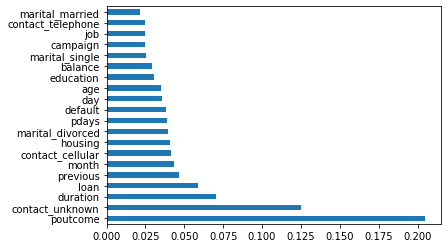

In [27]:

params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8,'n_estimators':1000}
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
xg.fit(X1_train,y_train)
feat_importances = pd.Series(xg.feature_importances_, index=cols)
feat_importances.nlargest(20).plot(kind='barh')